In [1]:
import os
import subprocess

import xarray as xr  
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Activation, Conv2D
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as kb

import keras_tuner as kt

import matplotlib.pyplot as plt
import matplotlib
from global_land_mask import globe

from sklearn import linear_model
import scipy.stats as ss

import random
import seaborn as sb
sb.set_style("white")

In [2]:
# Makes these global for potential editing within scripts
BASEVAR = sorted(['pr']) # the variables used for the ANN, always alphabetical 

PRIM = 'cmip6' #primary dataset for model training and validation
#observational dataset for model testing, dictionary from each VAR
OBS = {'tas':'BEST','pr':'CPC', 'cdd':'BEST', 'hdd':'BEST',
       'r95t':'ERA5', 'r95p':'ERA5', 'r99p':'ERA5', 'r99t':'ERA5'
      } 

TIMETYPE = 'annual' #are we using just 'annual' mean data (or seasonal)? Means each 'month'?
TIMERANGE = ['1920','2098']
RES = 'r90x45' # the resolution of the data, format: r90x45
REGION = 'globe-land' #'NA-land' # 'north_atl' # Define region in get_region_bounds, None is global

if TIMETYPE == 'month':
    varlist = []
    for var in BASEVAR:
        varlist.extend( [var + '-%02i' % num for num in np.arange(12)+1] )
    VAR = sorted(varlist)
else:
    VAR = BASEVAR

# Computer username
USER = 'Jamin' #laptop
USER = 'jrader' #work

ROOT = '/Users/' + USER + '/Rams/TOE_Research/' # root directory for the whole project
PATH = ROOT + 'data/' # the path of the netCDF files (before PRIM)
STAND_TYPE = 'classification/'
NETCDF_PATH = PATH + 'netcdfFiles_' + RES + '/'
NPZ_PATH = PATH + 'npzFiles_' + RES + '/' # Don't change this format
MOD_DIR = 'models/' + STAND_TYPE
PLOT_DIR = 'plots/' + STAND_TYPE
SAVE_LRP_PATH = PATH + 'lrp_npz_' + RES + '/' + STAND_TYPE
MASK = PATH + 'landmask/landmask_nopole_' + RES + '.npz'

MODEL_NUM = None # only used if loading a previously saved model
NEW_MODEL_NUM = None # used to overwrite a model number if model doesn't already exist

VAL_SPLIT = .2 # what fraction of the models should be used for validation?
CLOSS_YEAR = np.nan # setting the years for the loss function equal to nan for error checking
VAL_MODELS = None #[0,3, 9, 11] #[0,3, 9, 11] < for pr #[0,2, 6, 13, 15, 22] < for tas
    
REMOVE_GLOBAL_MEAN = False # Cannot do -land if REMOVE_GLOBAL_MEAN is true

ACTIVATION = 'relu' # The activation function used for the ANN
RIDGE_PENALTY = .01 #10 (for NA-land)
 
#VAL_MODELS = sorted([6, 20, 13, 10, 31, 17, 19])
RIDGE_PENALTY = .1

#['tas'] [ 9  5 22  3 17 30 21]
#['pr'] [ 6, 20, 13, 10, 31, 17, 19]
#['pr', 'tas'] [ 0 17 15 21  7 19 23]

#['tas-djf', 'tas-jja', 'tas-mam', 'tas-son'] [31 17 27 12 22 29 13]
#['pr-djf', 'pr-jja', 'pr-mam', 'pr-son'] [ 6 20 13 10 31 17 19]
# ['pr-djf', 'pr-jja', 'pr-mam', 'pr-son', 'tas-djf', 'tas-jja', 'tas-mam', 'tas-son'] [ 6 20 13 10 31 17 19] 

#['tas', month] [ 9  7 29 11 34 15 31]
#['pr', month] [24 15 12 14  1 28 19]
#['pr_tas', month] [23  5  6  2 11 35 34]

# r95p-seas-met >> [5,21,13,2,15,22]
# dd-seas-met >> [3, 19, 22, 9, 7 ,27]

LASSO = 0
LEARNING_RATE = 0.001 #.001
EPOCHS = 150
LAYERS = None #[10,10] #[10,10] has two layers with 10 nodes each, [] is linear
RANDOM_NETWORK_SEED = 41829

# Temporary Values

# random numbers
%env PYTHONHASHSEED=99
np.random.seed(seed=None)
tf.random.set_seed(99)



env: PYTHONHASHSEED=99


# Functions

In [9]:
####### TOE_functions, Jamin Rader ########

#####
### These functions are all for preparing the data (see prepare_data() below)
### Specifically, it takes the netcdf files at PATH, standardizes the data, 
### removes the annual mean, flattens it
#####
 
# User-defined regions
region_bounds = {
                'contig_us': {'lat':(25,50), 'lon':(235,295)},
                'north_atl': {'lat':(20,65), 'lon':(290, 350)},
                'NA': {'lat':(13,75), 'lon':(190, 304)},
                'globe': {'lat':(-90,90), 'lon':(0, 360)},
                'west' : {'lat':(-90,90), 'lon':(190, 352)},
                'americas' : {'lat':(-55,90), 'lon':(190, 335)}
                }
# Adds "land-only" option to region bounds dictionary
reg_keys = [i for i in region_bounds.keys()]
for i in reg_keys:
    region_bounds[i + '-land'] = region_bounds[i].copy()
                    
# Extracts the netcdf data, returns a list of all datasets
def get_nc_data():
    filenames = []
    datasets = []
    # List of lists with all filenames for each variable in each list with variable off the front
    for var in BASEVAR:
        fnames = []
        for fn in os.listdir(NETCDF_PATH+PRIM + '/' + var):
            if fn.endswith('.nc'):
                fnames.append(fn[len(var):])
        filenames.append(fnames)
        
    # Removes dislike filenames
    alike  = set(filenames[0])
    for i in range(1, len(filenames)):
        alike = alike & set(filenames[i])
    # 1-D list with all similar filenames, with variable off front
    filenames = sorted(list(alike))
    # Opening the netcdfs - each list element of 'datasets' is a netcdf file with all variables for given model
    for i in range(len(filenames)):
        fns = [NETCDF_PATH + PRIM + '/' + var + '/' + var + filenames[i] for var in BASEVAR]
        #print(fns)
        data = xr.open_mfdataset(fns, combine='by_coords', compat='override')
        #try:
        #    data = xr.open_mfdataset(fns, combine='by_coords', compat='override')
        #except:
        #    data = xr.open_mfdataset(fns, combine='nested', concat_dim='time')
        datasets.append(data)
    return datasets

def select_region(xr_array):

    if REGION == None:
        return xr_array
    lat_bounds = region_bounds[REGION]['lat']
    lon_bounds = region_bounds[REGION]['lon']
    xr_return = xr_array.sel(lat=slice(lat_bounds[0], lat_bounds[1])).sel(lon=slice(lon_bounds[0], lon_bounds[1]))
    return xr_return # CHANGED
    #if str(REGION).endswith('-land'):
        #maskinfo = np.load(MASK)
        #boolland, boollats, boollons = maskinfo['mask'], maskinfo['lats'], maskinfo['lons']
        #print('NEXT')
        #print(xr_return.values)
        #print(boolland)
        #boolland = np.stack(np.shape(xr_return)[0]*[boolland], axis=0)
        #xr_return = xr_return.copy() * (boolland * 1) # sets non land regions to zero
        #xr_return = xr_return.where(boolland == False, np.nan)
        
    return xr_return

def time_mean(xr_array):
    # Takes monthly averages and turns them into seasonal, annual averages
    if TIMETYPE == 'annual':
        array = xr_array.groupby("time.year").mean("time").values # Takes annual mean
    elif TIMETYPE == 'month':
        array = xr_array.values
    else: 
        print('timetype is undefined')# and the month thing here later
    return array

def mean_and_flatten(datasets):
    # Loop through datasets and turn month means into annual means
    data, years, models, lats, lons = [], [], [], [],[]
    for ds in datasets:
        flat_arrays = []
        try:
            models.append(ds.model_id)
        except:
            models.append(ds.source_id)
        #print(ds.source_id)
        ds = ds.sel(time=slice(TIMERANGE[0], TIMERANGE[1])) # Selects only the years specified by TIMERANGE

        for var in BASEVAR:
            #var = var.split('-')[0] #if separated by season or something
            xr_array = select_region(ds[var])
            if REMOVE_GLOBAL_MEAN:
                xr_array = xr_array - xr_array.mean(['lat', 'lon'], skipna=True)
            array = time_mean(xr_array)
            if TIMETYPE == 'month':
                flat_array = np.reshape(array, (np.shape(array)[0]//12, -1 )) #flatten if months
            else:
                flat_array = np.reshape(array, (np.shape(array)[0], -1 )) #flatten
            flat_arrays.append(flat_array) # appends flattened variable array
            if var == BASEVAR[-1]:
                lats = xr_array.lat.values
                lons = xr_array.lon.values
        flat_data = np.concatenate(flat_arrays, axis=1) # concatenates all the arrays together
        data.append(flat_data)
        years.append(sorted(list(set(ds.time.dt.year.values)))) # adds model years as list index
        
    return data, years, models, lats, lons

def prepare_data():
    datasets = get_nc_data()
    data, years, models, lats, lons = mean_and_flatten(datasets)
    return data, years, models, lats, lons

# Getting numpy arrays of the observational data

def get_obs():
    
    try:

        datasets = []

        # List of lists with all filenames for each variable in each list with variable off the front
        filenames = [NETCDF_PATH + 'observations/' + OBS[var.split('-')[0]] + '/' + var + '/' 
                     + var + '.' + OBS[var.split('-')[0]].lower() + '.' + 'monmean_' + RES + '.nc' 
                     for var in BASEVAR]

        # Opening the netcdfs - each list element of 'datasets' is a netcdf file with all variables for given model
        obs_year_range = [0,np.inf]
        for i in range(len(filenames)):
            filename = filenames[i]
            var = BASEVAR[i]
            global poodle #REMOVE
            poodle = filename #REMOVE
            ds = xr.open_dataset(filename)
            xr_array = ds[var]
            xr_array = select_region(xr_array)
            xr_array = xr_array.sel(time=slice(TIMERANGE[0], TIMERANGE[1])) # Selects only the years specified by TIMERANGE
            if REMOVE_GLOBAL_MEAN:
                xr_array = xr_array - xr_array.mean(['lat', 'lon'],skipna=True)
            year_list = xr_array.time.dt.year.values
            year_range = [np.min(year_list),np.max(year_list)]
            
            # Removes partial year at the beginning or end of the dataset
            if len(year_list[year_list == year_list[-1]]) != 12: year_range[1] = year_range[1]-1
            if len(year_list[year_list == year_list[0]]) != 12: year_range[0] = year_range[0]+1
            if year_range[0] > obs_year_range[0]: obs_year_range[0] = year_range[0]
            if year_range[1] < obs_year_range[1]: obs_year_range[1] = year_range[1]
            datasets.append(xr_array)

        flat_arrays = []
        for xr_array in datasets:
            xr_array = xr_array.sel(time=slice(str(obs_year_range[0]), str(obs_year_range[1]))) #common years
            obs_years = sorted(list(set(xr_array.time.dt.year.values)))
            array = time_mean(xr_array)
            if TIMETYPE == 'month':
                flat_array = np.reshape(array, (np.shape(array)[0]//12, -1 )) #flatten if months
            else:
                flat_array = np.reshape(array, (np.shape(array)[0], -1 )) #flatten

            flat_arrays.append(flat_array) # appends flattened variable array

        obs_data = np.concatenate(flat_arrays, axis=1)

        return obs_data, np.array(obs_years)
    
    except:
        print('No observational data for this variable.')
        return None, None

# Standardizing the data
# Taking out climate sensitivity--each mean and standard deviation is taken from each individual

def detrend(data, obs=False):
    detrended = np.zeros(np.shape(data))
    x = np.arange(np.shape(data)[-2])
    if obs:
        for gp in np.arange(np.shape(data)[-1]):
            regr = linear_model.LinearRegression()
            regr.fit(x.reshape(-1, 1), data[:,gp])
            trend = regr.predict(x.reshape(-1, 1))
            detrended[:,gp] = data[:,gp] - trend + np.mean(trend)
            
        return detrended
    
    else:
        for mod in np.arange(np.shape(data)[0]):
            for gp in np.arange(np.shape(data)[-1]):
                regr = linear_model.LinearRegression()
                regr.fit(x.reshape(-1, 1), data[mod,:,gp])
                trend = regr.predict(x.reshape(-1, 1))
                detrended[mod,:,gp] = data[mod,:,gp] - trend + np.mean(trend)

        return detrended

def decade_classes(classChunk=10):
    decades = np.arange(int(TIMERANGE[0]) - 5 - classChunk,int(TIMERANGE[1]) + 10.01 + classChunk, classChunk) 
    return decades
    

def convert_fuzzyDecade(intyears,classChunk=10):
    decades = decade_classes()
    labelmap = dict()
    for d in range(len(decades)):
        labelmap[d] = decades[d]
    
    classshape = tuple([s for s in intyears.shape]+ [len(decades)])
    
    preclass = intyears.flatten()[:, np.newaxis] - decades[np.newaxis, :] # Finds difference from each decade
    preclass = np.abs(preclass)-classChunk # Years less than 10 years from the decade will be negative
    preclass[preclass>=0] = 0 # Give all other years a zero, because
    # Assigns the probabilities to each year, these are our labels for training
    classyears = (np.abs(preclass)/classChunk).reshape(classshape)

    return classyears #labelmap, labelmap.keys()

def convert_fuzzyDecade_toYear(classprobs,classChunk=10):
    decades = decade_classes()
    intyears = np.sum(decades * classprobs, axis=-1)
    
    return intyears
    
    
def standardize_data(data, years, obs = [None, None]):
    
    if str(REGION).endswith('-land'):
        maskinfo = np.load(MASK)
        boolland, boollats, boollons = maskinfo['mask'], maskinfo['lats'], maskinfo['lons']

        # Change the mask based on the region
        latrange = region_bounds[REGION]['lat']
        lonrange = region_bounds[REGION]['lon']
        boolland = boolland[np.logical_and(boollats >= latrange[0], boollats <= latrange[1]), :]
        boolland = boolland[:, np.logical_and(boollons >= lonrange[0], boollons <= lonrange[1])]
        boollons = boollats[np.logical_and(boollats >= latrange[0], boollats <= latrange[1])]
        boollons = boollons[np.logical_and(boollons >= lonrange[0], boollons <= lonrange[1])]
        
        
        #if TIMETYPE == 'month': #CHANGED
        #    boolland = np.stack([boolland]*len(VAR)*12).flatten()
        #else:
        boolland = np.stack([boolland]*len(VAR)).flatten()
        data = data[:,:,boolland]
    
    boolyr = np.logical_and(years[0]<=2019, years[0] >= 1980) #2019, 1980
    years_class = convert_fuzzyDecade(years)
    
    data4standardizing = data[:,boolyr,:].copy()
    data4standardizing = detrend(data4standardizing) # removes the linear trend from each data gridpoint
    
    mean = np.stack([np.mean(data4standardizing, axis=1)]*np.shape(data)[1], axis=1)
    std = np.stack([np.std(data4standardizing, axis=1)]*np.shape(data)[1], axis=1)
    std = np.mean(std, axis=(0,1)) # Average standard deviation across models at each individual grid point

    std[std == 0] = 1 # Makes sure constant points don't divide by zero
    
    data_stand = (data - mean)/std # Standardize at each lat/lon point, across time

    if 'None' not in str(obs):
        obs_data, obs_years = obs
        
        if str(REGION).endswith('-land'):
            obs_data = obs_data[:,boolland]
        
        boolyr = np.logical_and(obs_years<=2019, obs_years >= 1980)
        
        data4standardizing = obs_data[boolyr,:].copy()
        data4standardizing = detrend(data4standardizing,obs=True) # removes the linear trend

        mean = np.nanmean(data4standardizing, axis=0) #first method
        #std = np.nanstd(data4standardizing, axis=0)
        
        obs_years_class = convert_fuzzyDecade(obs_years)
        obs_data_stand = (obs_data - mean) / std
        return data_stand, years_class, obs_data_stand, obs_years_class
    return data_stand, years_class, None, None # if observations aren't present
        
def unstandardize_years(classprobs):
    return convert_fuzzyDecade_toYear(classprobs)

def rmse(x, xi):
    return np.sqrt(np.sum((x - xi)**2/len(x)))

def mae(x, xi):
    return np.mean(np.abs(x - xi))
    
        
#####
### These functions create the npz_filename and save the netcdf data to a .npz file
#####

def make_npz_filename(directory_str):
    # make a filename like: cmip5_arrays_var=pr_tas_res=r90x45.npz
    npz_string = PRIM + '.timetype=' + TIMETYPE + '.timerange=' + TIMERANGE[0] + '_' + TIMERANGE[1] + '.var='
    
    #if TIMETYPE == 'month': #CHANGED
    #    varlist = []
    #    for var in VAR:
    #        varlist.extend( [var + '-%02i' % num for num in np.arange(12)+1] )
    #    for var in varlist:
    #        npz_string += var + '_'
    #else: 
    for var in BASEVAR:
        npz_string += var + '_'
    npz_string = npz_string[:-1] 
    if REGION != None:
        npz_string += '.reg=' + REGION
    npz_string += '.globalmeanrm=' + str(REMOVE_GLOBAL_MEAN)
    npz_string += '.res=' + RES + '.npz'
    return directory_str + npz_string

def save_data_to_npz(data, years, models, lats, lons):
    # Make directories for the data (such as npzFiles_r90x45)
    new_dir = PATH + '/npzFiles_' + RES +'/'
    subprocess.run(('mkdir ' + new_dir).split())
    fn_out = make_npz_filename(new_dir)
    np.savez(fn_out, data=data, years=years, models=models, lats=lats, lons=lons)
    print('Data saved to:', fn_out)
    #data, years, models, lats, lons = [savedarrays[i] for i in ['data', 'years', 'models', 'lats', 'lons']]
    
#####
### This function opens the saved .npz files from the netcdf data
#####

def get_npz_data(filename = None):
    
    global PRIM, TIMETYPE, TIMERANGE, VAR, RES, REGION, NPZ_PATH, REMOVE_GLOBAL_MEAN, BASEVAR

    if filename == None:
        for fn in os.listdir(NPZ_PATH):
            # Checking for correct PRIM, TIMETYPE, RES
            
            if (PRIM in fn) and ('.timetype=' + TIMETYPE in fn) and np.any('.res=' + RES in fn) \
                            and ('.globalmeanrm=' + str(REMOVE_GLOBAL_MEAN) in fn) \
                            and ('.timerange=' + TIMERANGE[0] + '_' + TIMERANGE[1] in fn):
                fn_vars = fn.split('var=')[1].split('.')[0].split('_')
                #Checking for correct REGION
                if (bool(REGION) == ('.reg=' in fn)) and (('reg=' + str(REGION) in fn.split('.')) == bool(REGION)):
                    #Checking for correct VAR
                    if BASEVAR == fn.split('var=')[1].split('.')[0].split('_'):
                        filename = fn
    else:
        PRIM = filename.split('.')[0]
        TIMETYPE = filename.split('timetype=')[1].split('.')[0]
        TIMERANGE = filename.split('timerange=')[1].split('.')[0].split('_')
        try:
            REGION = filename.split('reg=')[1].split('.')[0]
        except:
            REGION = None
        REMOVE_GLOBAL_MEAN = filename.split('globalmeanrm=')[1].split('.')[0] == 'True' #bool(True) if True
        RES = filename.split('res=')[1].split('.')[0]
        BASEVAR = filename.split('var=')[1].split('.')[0].split('_') #Changed 9-21-2021
        #VAR = filename.split('var=')[1].split('.')[0].split('_') #Changed 9-21-2021
        NPZ_PATH = PATH + 'npzFiles_' + RES + '/'
        
    if TIMETYPE == 'month':
        varlist = []
        for var in BASEVAR:
            varlist.extend( [var + '-%02i' % num for num in np.arange(12)+1] )
        VAR = sorted(varlist)
    else:
        VAR = BASEVAR
        
    if filename == None: # One last check to see if filename is still None
        print('Error: NPZ File Not Found')
    print(filename)
    npzdata = np.load(NPZ_PATH + filename);
    return npzdata['data'], npzdata['years'], npzdata['models'], npzdata['lats'], npzdata['lons']

#####
### Stores experiments specs into a dictionary
#####
def assign_model_num():
    model_nums = [] # list of model numbers that have already been assigned
    if NEW_MODEL_NUM:
        MODEL_NUM = NEW_MODEL_NUM
        return NEW_MODEL_NUM
    for saved_model in os.listdir(ROOT + MOD_DIR):
        if saved_model.endswith('.h5'):
            model_nums.append(int(saved_model.split('.')[1])) # adds model numbers that have been used
    if len(model_nums) < 1:
        model_nums=[0]
    return max(model_nums) + 1


def track_experiment(specs, train_model_ids, val_model_ids, history=None, update=False):
    
    specs['dataset info'] = {}
    specs['dataset info']['training dataset'] = PRIM
    specs['dataset info']['variables'] = VAR
    specs['dataset info']['base variables'] = BASEVAR
    #if TIMETYPE == 'month': # CHANGED
    #    varlist = []
    #    for var in VAR:
    #        varlist.extend( [var + '-%02i' % num for num in np.arange(12)+1] )
    #    specs['dataset info']['variables'] = varlist
    specs['dataset info']['resolution'] = RES
    specs['dataset info']['region'] = REGION
    specs['dataset info']['timetype'] = TIMETYPE
    specs['dataset info']['timerange'] = TIMERANGE
    specs['dataset info']['global mean remove'] = REMOVE_GLOBAL_MEAN
    specs['dataset info']['training models'] = train_model_ids
    specs['dataset info']['validation models'] = val_model_ids
    specs['dataset info']['validation model id numbers'] = VAL_MODELS
    
    
    specs['model info'] = {}
    specs['model info']['epochs'] = EPOCHS
    specs['model info']['act func'] = ACTIVATION
    specs['model info']['ridge pen'] = RIDGE_PENALTY
    specs['model info']['lasso'] = LASSO
    specs['model info']['learn rate'] = LEARNING_RATE
    specs['model info']['model layers'] = LAYERS
    specs['model info']['random seed'] = RANDOM_NETWORK_SEED
    
    if update:
        specs['model num'] = assign_model_num()

        specs['model result'] = {}
        try:
            specs['model result']['val loss'] = '%.4f' %history.history['val_loss'][-1]
            specs['model result']['train loss'] = '%.4f' %history.history['loss'][-1]
        except:
            specs['model result']['val loss'] = None
            specs['model result']['train loss'] = None    
        
    return specs



#####
### This function splits the data into training and validation datasets
#####

def validation_split(data_stand, years_stand, model_ids):
    global VAL_MODELS
    if type(VAL_MODELS) == type(None):
        # Number of the model for the validation dataset? (array of ints)
        VAL_MODELS = np.random.choice(len(data_stand), size = round(len(data_stand)*VAL_SPLIT), replace = False)
    val_models = VAL_MODELS

    val_data = data_stand[val_models] # validation dataset uses the val_num
    val_data = np.reshape(val_data, (np.product(np.shape(val_data)[0:2]), np.shape(val_data)[2]))
    val_years = years_stand[val_models]
    val_years = val_years.reshape(np.prod(val_years.shape[0:-1]),-1)
    train_data = np.delete(data_stand, val_models, axis=0) # training dataset (validation models removed)
    train_data = np.reshape(train_data, (np.product(np.shape(train_data)[0:2]), \
                                                     np.shape(train_data)[2]))
    train_years = np.delete(years_stand, val_models, axis=0)
    train_years = train_years.reshape(np.prod(train_years.shape[0:-1]),-1)
    
    val_model_ids = model_ids[val_models]
    train_model_ids = np.delete(model_ids, val_models, axis=0)
    
    return  train_data, train_years, train_model_ids, val_data, val_years, val_model_ids,

#####
### This function defines the neural network and training
#####

# Define random seed if RANDOM_(SEGMENT/NETWORK)_SEED == None
def random_seed(random_seed):
    if random_seed == None:
        random_seed = np.random.randint(10000)
    return random_seed

def define_NN(input_shape, output_shape):
    global RANDOM_NETWORK_SEED

    model = Sequential()
    RANDOM_NETWORK_SEED = random_seed(RANDOM_NETWORK_SEED)
    
    if len(LAYERS) == 0:
        # linear model
        model.add(Dense(1, input_shape=(input_shape,), activation='linear', use_bias=True, 
                       kernel_regularizer=regularizers.l1_l2(l1=LASSO, l2=RIDGE_PENALTY),
                       bias_initializer=tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED),
                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED)))

    else:
        # nonlinear model - initial layer
        model.add(Dense(LAYERS[0], input_shape=(input_shape,), activation=ACTIVATION, use_bias=True, 
                        kernel_regularizer=regularizers.l1_l2(l1=LASSO, l2=RIDGE_PENALTY),
                        bias_initializer=tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED),
                        kernel_initializer=tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED)))
        
        # subsequent layers
        for layer in LAYERS[1:]:
            model.add(Dense(layer, activation = ACTIVATION, use_bias = True, 
                            kernel_regularizer = regularizers.l1_l2(l1=0, l2=0),
                            bias_initializer = tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED),
                            kernel_initializer = tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED)))
    
    # output layer
    model.add(Dense(output_shape, activation=None, use_bias=True, 
                    kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0),
                    bias_initializer=tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED),
                    kernel_initializer=tf.keras.initializers.RandomNormal(seed=RANDOM_NETWORK_SEED), 
                    kernel_constraint=tf.keras.constraints.NonNeg()))
    model.add(Activation('softmax'))
    
    return model


def train_NN(x_train, y_train, x_val, y_val):
    output_shape = len(decade_classes())
    model = define_NN(np.shape(x_train)[1], output_shape)
    
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
                        initial_learning_rate=LEARNING_RATE, power=1,
                        decay_steps=10000, end_learning_rate=LEARNING_RATE/20)
    
    
    #lr_schedule = LEARNING_RATE # TEMPORARY
    
    #model.compile(optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum = 0.9, nesterov=True),
    #             loss = custom_loss, metrics=['mse'])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),
                 loss = 'binary_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
    history = model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, 
                        shuffle=True, verbose=0,
                        validation_data=(x_val, y_val))   
    return model, history

#####
### Save Model and Model Specifications (and also the function to retrieve them later)
#####

def check_model_exists(specs):
    global MODEL_NUM
    for modspec in os.listdir(ROOT + MOD_DIR):
        if modspec.endswith('.p'):
            f = open(ROOT + MOD_DIR + modspec,'rb')
            prev_specs = pickle.load(f) # specs from a model that was already created
            temp_prev_specs = prev_specs.copy()
            temp_specs = specs.copy()
            try: # deletes these if they already exist (but they prolly don't)
                del temp_prev_specs['model num'], temp_prev_specs['model result'], temp_specs['model num']
            except:
                pass 
            if str(temp_prev_specs) == str(temp_specs): # if the dictionary is the same as another (except model num)
                specs = prev_specs.copy() 
                MODEL_NUM = specs['model num']
                return True
    return False
                
            

def save_model(model, specs):
    model.save(ROOT + MOD_DIR + 'model.%03d.h5' % specs['model num'])
    f = open(ROOT + MOD_DIR + 'modelspecs.%03d.p' % specs['model num'],'wb')
    pickle.dump(specs,f)
    f.close()

def load_model(update_globals=True):
    # update_global updates the global variables above to fit the data the model was trained on
    model = tf.keras.models.load_model(ROOT + MOD_DIR + 'model.%03d.h5' % MODEL_NUM, compile=False)
    f = open(ROOT + MOD_DIR + 'modelspecs.%03d.p' % MODEL_NUM,'rb')
    specs = pickle.load(f)
    f.close()
    if update_globals:
        global VAR, PRIM, OBS, TIMETYPE, TIMERANGE, RES, REGION, REMOVE_GLOBAL_MEAN, VAL_MODELS, BASEVAR
        VAR = specs['dataset info']['variables']
        BASEVAR = specs['dataset info']['base variables']
        PRIM = specs['dataset info']['training dataset']
        TIMETYPE = specs['dataset info']['timetype']
        TIMERANGE = specs['dataset info']['timerange']
        RES = specs['dataset info']['resolution']
        REGION = specs['dataset info']['region']
        REMOVE_GLOBAL_MEAN = specs['dataset info']['global mean remove']
        VAL_MODELS = specs['dataset info']['validation model id numbers']
        
        global NETCDF_PATH, NPZ_PATH, SAVE_LRP_PATH, MASK
        NETCDF_PATH = PATH + 'netcdfFiles_' + RES + '/'
        NPZ_PATH = PATH + 'npzFiles_' + RES + '/' # Don't change this format
        SAVE_LRP_PATH = PATH + 'lrp_npz_' + RES + '/' + STAND_TYPE
        MASK = PATH + 'landmask/landmask_nopole_' + RES + '.npz'
        
    return model, specs
    
#####
### Plots Loss in Training
#####

def plot_error_loss(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(6,4))
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Error')
    plt.ylabel('Categorical Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    #plt.ylim(0, np.max([history.history['mse'][50:], history.history['val_mse'][50:]]))
    #plt.xlim(50,EPOCHS)
    
#####
### Predict years and plot the results
#####

def plot_results(y_train, train_predict, y_val, val_predict, y_obs, obs_predict, title):
    
    plt.figure(figsize=(8,8))
    
    try:
        val_color = ['#cd5d5d','#6495ed','#dda338',
                     '#b63838','#2461cf','#9a7227',
                     '#6d2121','#143673','#584116', '#FF00FF', '#b63838'][MODEL_NUM-1]
        print(val_color)
    except:
        val_color = 'coral'
    
    plt.plot(y_train, train_predict, '.k', alpha=.3, markersize=10, label='Training Data')
    plt.plot(y_val, val_predict, '.', color = val_color, markersize = 10, label='Validation Data')
    
    if type(y_obs) != type(None):
        plt.plot(y_obs, obs_predict, 'o', color='black', markerfacecolor = 'white', markersize = 8, 
                 markeredgewidth=2.2, label='Observations')
    ts = 2 # textsize parameters
    minyear = np.min(y_train)
    maxyear = np.max(y_train)
    plt.plot([int(TIMERANGE[0])-5, int(TIMERANGE[1])+5], [int(TIMERANGE[0])-5, int(TIMERANGE[1])+5], 'k--')
    #plt.legend()
    tcks = [1930, 1970, 2010, 2050, 2090]
    plt.yticks(tcks, fontsize=11*ts, fontweight='demi')
    plt.xticks(tcks, fontsize=11*ts, fontweight='demi')
    plt.xlabel('Truth Year',fontsize=12*ts, fontweight='demi')
    plt.ylabel('Predicted Year',fontsize=12*ts, fontweight='demi')
    plt.title("Training: " + PRIM.upper() + ' ' + str(VAR) + ' Region=' + str(REGION), 
              size=13*ts, fontweight='demi')
    plt.grid()#axis='y')
    plt.ylim(int(TIMERANGE[0])-20,int(TIMERANGE[1])+30)
    plt.xlim(int(TIMERANGE[0])-5, int(TIMERANGE[1])+5)
    if title:
        plt.title(title, size = 13*ts, fontweight='demi')
    #plt.tight_layout()
    plt.savefig(PLOT_DIR + '/year_pred/model' + str(MODEL_NUM) + '.jpg', dpi=300, bbox_inches='tight')
    plt.show()

def predict_and_plot(model, x_train, y_train, x_val, y_val, yearmax, yearmin, datashape, obs, makeplot=True, 
                     title=None):

    y_val = unstandardize_years(y_val)
    y_train = unstandardize_years(y_train)
    train_predict = model.predict(x_train).squeeze()
    train_predict = unstandardize_years(train_predict)
    val_predict = model.predict(x_val).squeeze()
    val_predict = unstandardize_years(val_predict)
    if type(obs[0]) != type(None):
        x_obs, y_obs = obs
        y_obs = unstandardize_years(y_obs)
        obs_predict_stand = model.predict(x_obs).squeeze()
        obs_predict = unstandardize_years(obs_predict_stand)
    else:
        y_obs, obs_predict = None, None
        
    if makeplot:
        plot_results(y_train, train_predict, y_val, val_predict, y_obs, obs_predict, title)
    
    # Creating an array of predicted years that matches the shape of the original data
    pred_train_shape = datashape[0] - len(VAL_MODELS)
    pred_years = np.reshape(train_predict, (pred_train_shape, -1))
    val_pred_years = np.reshape(val_predict, (len(VAL_MODELS), -1))
    
    for i in sorted(VAL_MODELS):
        pred_years = np.insert(pred_years, i, 0, axis=0)
    for i in range(len(VAL_MODELS)):
        pred_years[VAL_MODELS[i], :] = val_pred_years[i,:]

    try:
        return pred_years, train_predict, val_predict, obs_predict
    except:
        return pred_years, train_predict, val_predict, None

def model_info(model_num=None, return_dict = False):
    if not model_num:
        model_num = MODEL_NUM
    f = open(ROOT + MOD_DIR + 'modelspecs.%03d.p' % model_num,'rb')
    specs = pickle.load(f)
    f.close()
    if return_dict:
        return specs
    print(specs)
    
def save_data_for_lrp(data_stand, obs_data_stand, years, obs_years, pred_years, lats, lons, fn_out = None):
    if not fn_out:
        fn_out = SAVE_LRP_PATH + 'lrp_model' + str(MODEL_NUM) + '.npz'
    print(np.shape(data_stand))
    np.savez(fn_out, data=data_stand, obs=obs_data_stand, years=years, 
             obs_years=obs_years, pred_years=pred_years, lats=lats, lons=lons)
    print('Saved to LRP at ' + fn_out)

In [4]:
#data, years, model_ids, lats, lons = prepare_data()
#save_data_to_npz(data, years, model_ids, lats, lons)
#save_model(model, specs_dict)

In [5]:
#landlons, landlats = lons, lats
#landlons = landlons - 360 * np.floor(landlons/180) #switch from 0-360 to -180 to 180
#lon_grid, lat_grid = np.meshgrid(landlons,landlats)
#boolland = globe.is_land(lat_grid,lon_grid)
#boolland[lats < -60] = False
#np.savez('/Users/jrader/Rams/TOE_Research/data/landmask/landmask_r90x45', mask=boolland, lats=lats,lons=lons)

In [6]:
# Getting the data from netcdf to NPZ format
#data, years, model_ids, lats, lons = prepare_data()
#save_data_to_npz(data, years, model_ids, lats, lons)

# Load Neural Network instead of Training
MODEL_NUM = None
NEW_MODEL_NUM = None # If model number is being replaced

if MODEL_NUM:
    ___, specs_dict = load_model(update_globals = True)

# Getting the data from NPZ
npzfn = PRIM.lower() + '.timetype=' + TIMETYPE.lower() + '.timerange=' + '_'.join(TIMERANGE) \
        + '.var=' + '_'.join(BASEVAR) + '.reg=' + REGION.lower() + '.globalmeanrm=' + str(REMOVE_GLOBAL_MEAN) \
        + '.res=' + RES + '.npz'
data, years, model_ids, lats, lons = get_npz_data(filename=npzfn) # Gets training data
obs_data, obs_years = get_obs() # Gets observational data, prepared same as training data

# Now standardizing the data
data_stand, years_class, obs_data_stand, obs_years_class \
    = standardize_data(data, years, obs = (obs_data, obs_years))

cmip6.timetype=annual.timerange=1920_2098.var=pr.reg=globe-land.globalmeanrm=False.res=r90x45.npz


In [10]:
VAL_MODELS_list = [[0, 2, 4, 7, 25, 27, 31],
              [0, 9, 10, 18, 22, 30, 32],
              [1, 6, 15, 19, 23, 28, 33],
              [11, 15, 24, 29, 32, 33, 35],
              [4, 10, 18, 20, 25, 28, 33],
              [7, 10, 11, 13, 27, 28, 35],
              [0, 6, 14, 18, 20, 27, 33],
              [0, 15, 25, 31, 34, 35, 36],
              [3, 12, 14, 18, 19, 22, 28],
              [1, 2, 5, 8, 11, 14, 31]]


# Validation models (randomly generated) for r95p experiment
#VAL_MODELS_list = [[4, 9, 12, 19, 21, 24],
#               [0, 2, 8, 18, 28, 30],
#               [0, 2, 16, 18, 22, 28],
#               [1, 4, 19, 21, 28, 30],
#               [5, 10, 13, 18, 20, 24]][VAL_MODELS_ktNUM]

In [11]:
trainlossresults = np.zeros((3, 4, 10))
vallossresults = np.zeros((3, 4, 10))
valrmseresults = np.zeros((3, 4, 10))

#trainlossresults = np.zeros((1, 1, 10))
#vallossresults = np.zeros((1, 1, 10))
#valrmseresults = np.zeros((1, 1, 10))

for ilay, N_LAYERS in enumerate([1,2,3]): #enumerate([0]): #
    
    for inod, N_NODES in enumerate([5, 10, 20, 50]): #enumerate([0]): #

        for kt_valmod_id in range(10):

            VAL_MODELS = VAL_MODELS_list[kt_valmod_id]

            # splitting the standardized data into validation and training datasets
            train_data, train_years, train_model_ids, val_data, val_years, val_model_ids\
                = validation_split(data_stand, years_class, model_ids) 

            train_years_raw = unstandardize_years(train_years) #unclassify the years
            val_years_raw = unstandardize_years(val_years) #unclassify the years

            def main():

                global LAYERS
                
                LAYERS = N_LAYERS * [N_NODES] #[10,10] has two layers with 10 nodes each, [] is linear
                    
                print(LAYERS, kt_valmod_id)

                ### DON'T CHANGE ANYTHING BELOW HERE! ###

                # Start experiment tracking
                specs_dict = track_experiment({}, train_model_ids, val_model_ids)


                print('New experiment. Training ANN.')
                model, history = train_NN(train_data, train_years, val_data, val_years)
                
                val_predict = model.predict(val_data).squeeze()
                val_predict = unstandardize_years(val_predict)

                return history.history['loss'][-1], history.history['val_loss'][-1], rmse(val_years_raw, val_predict)

            trainloss, valloss, valrmse = main()

            trainlossresults[ilay][inod][kt_valmod_id] = trainloss
            vallossresults[ilay][inod][kt_valmod_id] = valloss
            valrmseresults[ilay][inod][kt_valmod_id] = valrmse


[5] 0
New experiment. Training ANN.
relu
[5] 1
New experiment. Training ANN.
relu
[5] 2
New experiment. Training ANN.
relu
[5] 3
New experiment. Training ANN.
relu
[5] 4
New experiment. Training ANN.
relu
[5] 5
New experiment. Training ANN.
relu
[5] 6
New experiment. Training ANN.
relu
[5] 7
New experiment. Training ANN.
relu
[5] 8
New experiment. Training ANN.
relu
[5] 9
New experiment. Training ANN.
relu
[10] 0
New experiment. Training ANN.
relu
[10] 1
New experiment. Training ANN.
relu
[10] 2
New experiment. Training ANN.
relu
[10] 3
New experiment. Training ANN.
relu
[10] 4
New experiment. Training ANN.
relu
[10] 5
New experiment. Training ANN.
relu
[10] 6
New experiment. Training ANN.
relu
[10] 7
New experiment. Training ANN.
relu
[10] 8
New experiment. Training ANN.
relu
[10] 9
New experiment. Training ANN.
relu
[20] 0
New experiment. Training ANN.
relu
[20] 1
New experiment. Training ANN.
relu
[20] 2
New experiment. Training ANN.
relu
[20] 3
New experiment. Training ANN.
relu
[2

In [9]:
vallossresults

array([[[0.13118376, 0.12955107, 0.12821573, 0.12928326, 0.13240775,
         0.1285458 , 0.12940578, 0.1293768 , 0.13003903, 0.12746041]]])

Text(0.5, 1.0, 'Validation Loss')

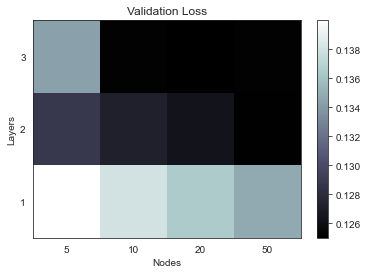

In [12]:
plt.pcolormesh(vallossresults.mean(axis=-1), cmap='bone')
plt.ylabel('Layers')
plt.yticks(ticks = [.5, 1.5, 2.5], labels = ["1", "2", "3"])
plt.xlabel('Nodes')
plt.xticks(ticks = [.5, 1.5, 2.5, 3.5], labels = ["5", "10", "20", "50"])
plt.colorbar()
plt.title('Validation Loss')
#plt.savefig('pr_train_loss_tuning.png', dpi=300)

In [20]:
#prvallossresults = vallossresults.copy()

In [48]:
vallossresults.mean(axis=-1)

array([[0.14546502]])

In [13]:
np.save('trainlossresults_pr_relu.npy', trainlossresults)
np.save('vallossresults_pr_relu.npy', vallossresults)
#np.save('trainlossresults_pr_relu.npy', trainlossresults)
#np.save('vallossresults_pr_relu.npy', vallossresults)

In [34]:
trainlossresultstemp.shape

(5,)

In [14]:
loss_pr_relu = np.load('vallossresults_pr_relu.npy')
rmse_pr_relu = np.load('valrmseresults_pr_relu.npy')
loss_pr_lin = np.load('vallossresults_pr_lin.npy')
rmse_pr_lin = np.load('valrmseresults_pr_lin.npy')

loss_tas_relu = np.load('vallossresults_tas_relu.npy')
rmse_tas_relu = np.load('valrmseresults_tas_relu.npy')
loss_tas_lin = np.load('vallossresults_tas_lin.npy')
rmse_tas_lin = np.load('valrmseresults_tas_lin.npy')

In [72]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def create_tune_matrix(mat_nonlin, mat_lin, func=np.mean, title = 'Loss'):
    loss_matrix = np.full((4,5), np.nan)
    loss_matrix[0,0] = func(mat_lin)
    loss_matrix[1:, 1:] = func(mat_nonlin, axis=-1)
    
    n = 13
    cmap = matplotlib.cm.get_cmap("bone", n)
    cmap = truncate_colormap(cmap, 1/n, (n-2)/n)
    #cmap = matplotlib.colors.LinearSegmentedColormap('bone', N=4)
    
    plt.pcolormesh(loss_matrix, vmin = .1, vmax=.15, cmap = cmap)
    plt.ylabel('# Hidden Layers', size=15)
    plt.yticks(ticks = [.5, 1.5, 2.5, 3.5], labels = ["linear", "1", "2", "3"], size=15)
    plt.xlabel('# Nodes per Layer', size=15)
    plt.xticks(ticks = [.5, 1.5, 2.5, 3.5, 4.5], labels = ["linear", "5", "10", "20", "50"], size=15)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label("Loss", size=15)
    plt.title(title, size=15)
    
    if True:
        for b in np.arange(5):
            for a in np.arange(4):
                try:
                    plt.text(b+.25, a+.43, '%.3f' %loss_matrix[a,b], fontweight='demibold', size=12, color='white')
                except:
                    print('No')
                    
    plt.savefig(title + '.png', dpi=300, bbox_inches='tight')
    plt.show()

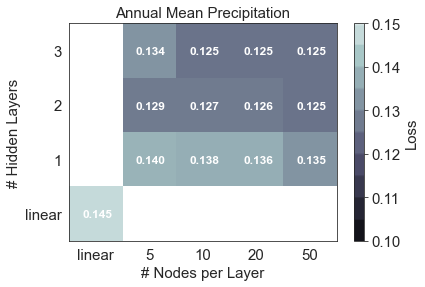

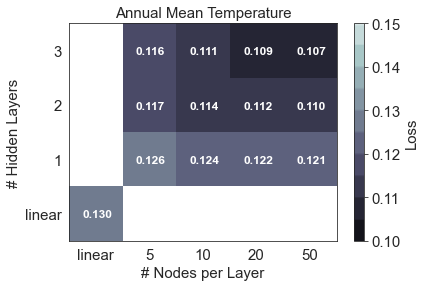

In [73]:
#create_tune_matrix(loss_pr_relu, loss_pr_lin, title='Annual-Mean Precipitation Maximum Validation Loss', func=np.max)
create_tune_matrix(loss_pr_relu, loss_pr_lin, title='Annual Mean Precipitation')
#create_tune_matrix(loss_pr_relu, loss_pr_lin, title='Loss', func=np.min)
#create_tune_matrix(loss_pr_relu, loss_pr_lin, title='Loss', func=np.max)
#create_tune_matrix(loss_tas_relu, loss_tas_lin, title='Annual-Mean Temperature Maximum Validation Loss',
#                   func = np.max)
create_tune_matrix(loss_tas_relu, loss_tas_lin, title='Annual Mean Temperature')

In [24]:
loss_pr_lin.mean()

0.1454650228493754

In [72]:
rmse_pr_lin

array([[[23.63592629, 23.7524065 , 22.16555181, 22.76841878,
         25.38775135]]])